<a href="https://colab.research.google.com/github/dkgithub/wiehl24/blob/main/skorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Working with PyTorch can become involved. There are many tool that try to avoid writimg out all the litlle details.
Most commonly used is lighning. Here, we use skorch. It provides a Keras like interface that interacts smoothly with sklearn.

In [3]:
#!rm -rf helpers # if an enforced reinstall is necessary
![ ! -d helpers ] && git clone --recursive https://github.com/dkgithub/erum_ml_school_helpers helpers
!pip install wget

In [4]:
!pip install wget torchinfo skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 3.0 MB/s eta 0:00:00


In [5]:
# load the helpers package and other software
import helpers as hlp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torchinfo

In [6]:
#check for accelerators
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('torch',torch.__version__)
print('device type is',device)
if device == 'cuda' :print(torch.cuda.get_device_name())
from os import environ
if "COLAB_TPU_ADDR" in environ and environ["COLAB_TPU_ADDR"]:
  print("A TPU is connected.")


torch 2.1.0+cu121
device type is cuda


In [7]:
# first, we define a preprocessing function that (e.g.) takes the
# constiuents and returns another representation of them

#def preprocess_constituents(constituents):
#    return constituents[:, :120].reshape((-1, 480))

def preprocess_constituents(constituents):
  # sum all constituents to get jet 4-momenta
  c_sum=constituents.sum(axis=1)
  metric=np.array([1.,-1.,-1.,-1.]) #g_mu_nu
  # calculating invariants wrt. to jet
  c_inv=(constituents*metric*c_sum[:,None,:]).sum(axis=2)
  return c_inv



In [8]:
# here, we define a function to construct the datasets
def makeDataset(name=None,nFiles=None):
  if name not in ['train','valid','test']:
    print(f'Need a proper data split name')
    return
  if name == 'train' and nFiles == None: nFiles = 2
  else: nFiles = 1
  c_vectors, _, labels = hlp.data.load(name, stop_file=nFiles)
  # run the preprocessing
  c_vectors = preprocess_constituents(c_vectors)
  # create torch tensors from numpy arrays, map to float32,
  # and move to GPU if available - device must be defined
  c_tensor      = torch.from_numpy(c_vectors).float()
  label_tensor  = torch.from_numpy(labels   ).float()
  # Then, we create a dataset from our tensors
  print(f'dataset {name} \tlength',len(label_tensor),'\tshape',c_tensor.shape)
  return torch.utils.data.TensorDataset(c_tensor,label_tensor)

In [9]:
ds_train = makeDataset('train')
ds_valid = makeDataset('valid')
ds_test  = makeDataset('test')

dataset train 	length 100000 	shape torch.Size([100000, 200])
dataset valid 	length 50000 	shape torch.Size([50000, 200])
dataset test 	length 50000 	shape torch.Size([50000, 200])


Skorch works with callbacks. Callbacks are called at certain points in the processing loop. Especially: epoch start,epoch end, batch start and batch end. Most common callbacks, e.g. scoring are predefined.

In [10]:
from skorch.callbacks import EpochScoring, EpochTimer
auc = EpochScoring(scoring='roc_auc',  lower_is_better=False)
acc = EpochScoring(scoring='accuracy', on_train=True, lower_is_better=False)

Skorch likes to create train and valid split internally but we already have our data splitted. There is a helper function for this situation *predefined_split*. For the *fit* method below we still have to give x and label (dataset.tensors[1]) separately.

In [11]:
from skorch.helper import predefined_split

In [21]:
# we construct a network
from torch import nn
class myModel(nn.Module):
  def __init__(self,in_size=200,mid_size=200,n_layers=5):
    super().__init__()
    self.in_size  = in_size
    self.mid_size = mid_size
    self.n_layers = n_layers
    self.inLay    = nn.Linear(in_size,mid_size)
    self.linears  = nn.ModuleList([nn.Linear(mid_size, mid_size) for i in range(n_layers)])
    self.bnorms   = nn.ModuleList([nn.BatchNorm1d(mid_size) for i in range(n_layers)])
    self.outLay   = nn.Linear(mid_size, 1)

  def forward(self, x):
    x = self.inLay(x)
    x = torch.relu(x)
    # ModuleList can act as an iterable, or be indexed using ints
    for i,lay in enumerate(self.linears):
      x = lay(x)
      self.bnorms[i](x)
      x = torch.relu(x)
    x = self.outLay(x)
    x = torch.sigmoid(x)
    return x

# we initiate the model
model=myModel()

Now, we can define our classifier and fit (train) it.

In [22]:

from skorch import NeuralNetClassifier
net = NeuralNetClassifier(
    model,
    criterion=nn.BCELoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    batch_size=500,
    max_epochs=10,
    callbacks=[acc,auc],
    train_split=predefined_split(ds_train),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    #callbacks=[LivePlot],
    device=device
)

In [23]:
net.fit(ds_train, ds_train.tensors[1])

  epoch    accuracy    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ----------  ---------  ------------  -----------  ------------  ------
      1      0.8143     0.9328        0.4506       0.8928        0.3023  2.0566
      2      0.8944     0.9407        0.2886       0.8984        0.2745  2.3468
      3      0.8978     0.9465        0.2704       0.8998        0.2608  2.0244
      4      0.8984     0.9498        0.2614       0.9009        0.2560  2.9621
      5      0.8983     0.9545        0.2547       0.9014        0.2472  2.0281
      6      0.9001     0.9567        0.2510       0.9023        0.2431  2.3251
      7      0.9005     0.9512        0.2487       0.8981        0.2577  2.0485
      8      0.9015     0.9571        0.2475       0.9043        0.2405  2.0480
      9      0.9014     0.9573        0.2469       0.9042        0.2398  3.0002
     10      0.9025     0.9580        0.2432       0.9022        0.2404  2.0579


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=myModel(
    (inLay): Linear(in_features=200, out_features=200, bias=True)
    (linears): ModuleList(
      (0-4): 5 x Linear(in_features=200, out_features=200, bias=True)
    )
    (bnorms): ModuleList(
      (0-4): 5 x BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (outLay): Linear(in_features=200, out_features=1, bias=True)
  ),
)

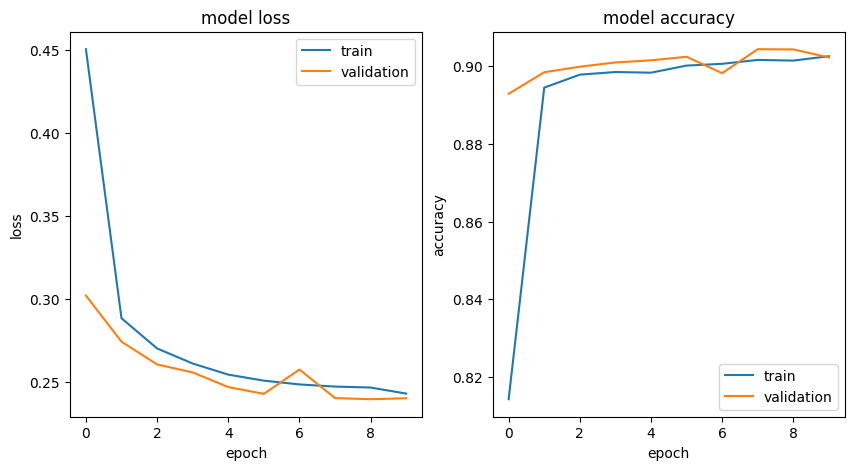

min train loss 0.243 at ep. 9
min valid loss 0.240 at ep. 8
best valid accurracy   0.90 at ep. 7


In [24]:
hlp.plots.plotLearningCurvesSkorch(net.history)

Maybe not yet the optimal accuracy.
Skorch allows to continue the traing: partial_fit instaed of fit.

In [29]:
net.partial_fit(ds_train, ds_train.tensors[1])

     11      0.9027     0.9545        0.2431       0.8982        0.2493  2.0442
     12      0.9028     0.9589        0.2409       0.9051        0.2359  2.3532
     13      0.9039     0.9602        0.2398       0.9070        0.2326  2.0432
     14      0.9052     0.9604        0.2371       0.9074        0.2352  2.7826
     15      0.9043     0.9610        0.2381       0.9073        0.2310  2.5254
     16      0.9044     0.9608        0.2381       0.9084        0.2306  2.0451
     17      0.9059     0.9601        0.2344       0.9081        0.2322  2.0780
     18      0.9059     0.9606        0.2332       0.9054        0.2333  2.0585
     19      0.9063     0.9627        0.2328       0.9097        0.2256  2.9047
     20      0.9077     0.9619        0.2305       0.9095        0.2270  2.1768


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=myModel(
    (inLay): Linear(in_features=200, out_features=200, bias=True)
    (linears): ModuleList(
      (0-4): 5 x Linear(in_features=200, out_features=200, bias=True)
    )
    (bnorms): ModuleList(
      (0-4): 5 x BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (outLay): Linear(in_features=200, out_features=1, bias=True)
  ),
)

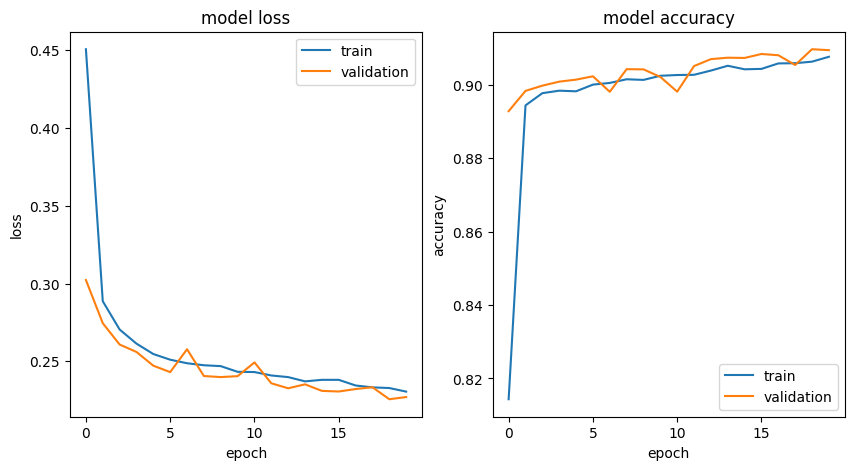

min train loss 0.231 at ep. 19
min valid loss 0.226 at ep. 18
best valid accurracy   0.91 at ep. 18


In [30]:
hlp.plots.plotLearningCurvesSkorch(net.history)

In [31]:
net.partial_fit(ds_train, ds_train.tensors[1])

     21      0.9073     0.9626        0.2301       0.9089        0.2251  2.3562
     22      0.9078     0.9629        0.2300       0.9081        0.2306  2.4973
     23      0.9079     0.9619        0.2283       0.9093        0.2258  2.8769
     24      0.9094     0.9644        0.2266       0.9116        0.2198  2.2211
     25      0.9094     0.9653        0.2260       0.9134        0.2192  2.0468
     26      0.9107     0.9643        0.2236       0.9111        0.2208  2.3446
     27      0.9116     0.9652        0.2223       0.9138        0.2163  2.0314
     28      0.9113     0.9654        0.2217       0.9143        0.2147  2.5244
     29      0.9123     0.9663        0.2183       0.9148        0.2120  2.4750
     30      0.9130     0.9661        0.2181       0.9148        0.2130  2.3008


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=myModel(
    (inLay): Linear(in_features=200, out_features=200, bias=True)
    (linears): ModuleList(
      (0-4): 5 x Linear(in_features=200, out_features=200, bias=True)
    )
    (bnorms): ModuleList(
      (0-4): 5 x BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (outLay): Linear(in_features=200, out_features=1, bias=True)
  ),
)

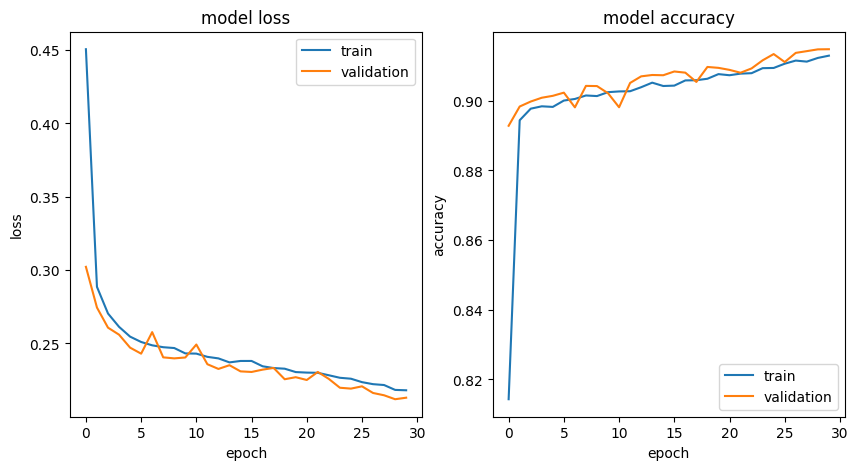

min train loss 0.218 at ep. 29
min valid loss 0.212 at ep. 28
best valid accurracy   0.91 at ep. 29


In [32]:
hlp.plots.plotLearningCurvesSkorch(net.history)

Still improvement, we need more then 10 additional epochs.

In [35]:
net.max_epochs=30
net.partial_fit(ds_train, ds_train.tensors[1])

     32      0.9135     0.9679        0.2167       0.9163        0.2089  2.0417
     33      0.9143     0.9660        0.2147       0.9153        0.2122  2.0695
     34      0.9148     0.9672        0.2129       0.9183        0.2098  2.9801
     35      0.9148     0.9690        0.2119       0.9202        0.2046  2.0410
     36      0.9160     0.9667        0.2094       0.9157        0.2107  2.3168
     37      0.9170     0.9705        0.2088       0.9204        0.2006  2.0487
     38      0.9178     0.9685        0.2066       0.9197        0.2040  2.0583
     39      0.9184     0.9700        0.2056       0.9206        0.2016  2.9404
     40      0.9182     0.9719        0.2060       0.9230        0.1945  2.0639
     41      0.9197     0.9698        0.2022       0.9203        0.1993  2.2738
     42      0.9207     0.9712        0.1989       0.9227        0.1955  2.0656
     43      0.9213     0.9725        0.1981       0.9252        0.1914  2.3188
     44      0.9220     0.9718        0.

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=myModel(
    (inLay): Linear(in_features=200, out_features=200, bias=True)
    (linears): ModuleList(
      (0-4): 5 x Linear(in_features=200, out_features=200, bias=True)
    )
    (bnorms): ModuleList(
      (0-4): 5 x BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (outLay): Linear(in_features=200, out_features=1, bias=True)
  ),
)

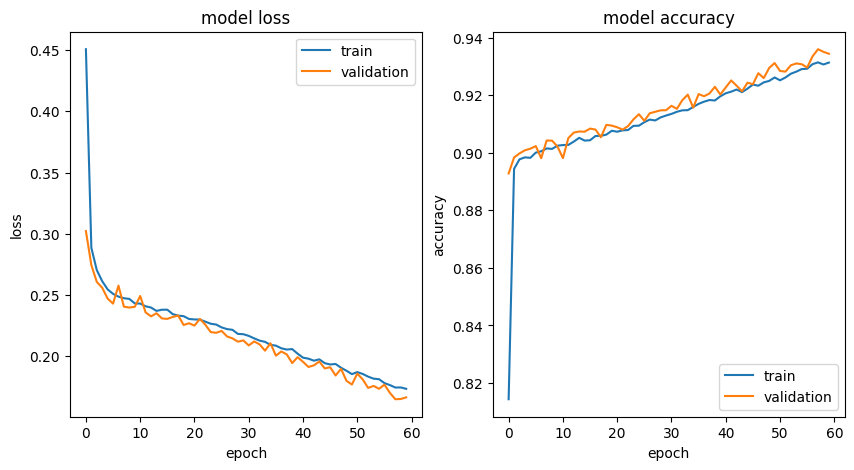

min train loss 0.174 at ep. 59
min valid loss 0.165 at ep. 57
best valid accurracy   0.93 at ep. 57


In [36]:
hlp.plots.plotLearningCurvesSkorch(net.history)

Scikit-learn provides a  grid search for the best hyperparameter (GridSearchCV). Skorch works smootly with this.

In [20]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)
params = {
    'lr': [0.001, 0.002, 005],
    'module__mid_size': [50,100,200,400,600],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy')

gs.fit(ds_train.tensors[0], ds_train.tensors[1])
print(gs.best_score_, gs.best_params_)

0.8985600025796862 {'lr': 0.002, 'module__mid_size': 400}


In [28]:
from copy import deepcopy
old=deepcopy(net.history)